# Import libs

In [24]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import scanpy as sc
import anndata as ad
import tangram as tg
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(10)


%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
torch.cuda.empty_cache()
device = torch.device("cpu")

In [3]:
# project_location = "e:/projects/stloc/"
project_location = "./"

# Load data

## Spatial data

In [4]:
df_st = pd.read_csv(project_location + "data/merfish/merfishSpatial.csv", sep=" ")
coords = df_st['coord']
df_st.drop(columns=['coord'], inplace=True)
cellTypeCount =16
typeCountDf=  df_st.iloc[:,-cellTypeCount:]
# df_st = df_st.iloc[: , :-cellTypeCount]
df_st.head()


,Ace2,Adora2a,Aldh1l1,Amigo2,Ano3,Aqp4,Ar,Arhgap36,Avpr1a,Avpr2,...,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.000000,0.631323,2.783859,4.017283,0.707772,2.754597,1.262664,14.922339,0.707772,0.0,...,0,0,0,1,1,0,0,0,0,0
1,0.000000,0.000000,5.027816,0.000000,0.000000,10.056050,0.000000,0.000000,0.000000,0.0,...,0,0,0,1,0,0,0,0,0,0
2,0.000000,0.000000,0.000000,0.000000,0.000000,3.856702,0.000000,0.854257,0.427118,0.0,...,0,0,0,1,1,0,0,0,0,0
3,0.000000,0.000000,1.465245,0.732607,0.000000,2.323503,0.795436,0.732607,0.732607,0.0,...,0,0,0,2,0,0,0,0,0,0
4,6.311896,7.574326,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0,0,1,0,0,1,0,0,0,0


In [5]:
typeCountDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0


In [6]:
reference = pd.read_csv(project_location + "data/merfish/markerGene_for_merfish_data.csv")

reference.drop(columns=['p_value'], inplace=True)
# reference.drop(range(148,168))
reference.drop(reference.index[reference.cell_type=='EpendymalInhibitory'].tolist(), inplace=True)
reference['cell_type'] = reference['cell_type'].astype(str).str.replace(" ", "")
reference.head()

,cell_type,marker_gene
0,Astrocyte,Aldh1l1
1,Astrocyte,Aqp4
2,Astrocyte,Cxcl14
3,Astrocyte,Mlc1
4,Astrocyte,Ttyh2


In [7]:
genes = df_st.columns[:155]
markers = reference.groupby('cell_type').agg(list).marker_gene
celltypes = reference.cell_type.unique().tolist()
expressions = df_st.drop(columns=celltypes)
expressions = MinMaxScaler().fit_transform(expressions)
counts_st = pd.DataFrame(expressions, columns=genes)
cellcount = pd.DataFrame(np.sum(df_st[celltypes], axis=1), columns=['cellcount'])

In [38]:
print(cellcount)
zero = (cellcount==0).sum()
print('zero count is',zero)
len(celltypes)


      cellcount
0             4
1             1
2             2
3             2
4             2
...         ...
1244          4
1245          1
1246          3
1247          5
1248          1

[1249 rows x 1 columns]
zero count is cellcount    0
dtype: int64


1

## Single-cell data

In [9]:
df_sc = pd.read_csv(project_location + "data/merfish/merfishVisium.csv")

In [10]:
counts_sc = df_sc[genes]
obs_sc = df_sc[[x for x in df_sc.columns if x not in genes]]
obs_sc.head()

,Cell_ID,Animal_ID,Animal_sex,Behavior,Bregma,Centroid_X,Centroid_Y,Cell_class,Neuron_cluster_ID
0,1f9a8c19-b089-43d1-b609-7e791dc2c70f,1,Female,Naive,-0.24,-3749.176078,-3749.458442,Astrocyte,NaN
1,b13e98f4-5c2b-4e96-985e-3e93aedc7221,1,Female,Naive,-0.24,-3746.226210,-3742.259347,Inhibitory,I-1
2,d06cb29e-10ee-4bbc-b74e-90237999ef4b,1,Female,Naive,-0.24,-3742.897643,-3790.648737,Inhibitory,I-13
3,12e2a165-57c7-4f37-96dd-23f6574af4ba,1,Female,Naive,-0.24,-3738.423005,-3773.259265,Inhibitory,I-19
4,14a0f396-b13d-4d45-89a3-86c2047bf3f9,1,Female,Naive,-0.24,-3736.407620,-3895.590306,Pericytes,NaN


In [11]:
obs_sc.shape
obs_sc.loc[0,"Cell_class"]

'Astrocyte'

# Tangram

In [13]:
adata_sc = ad.AnnData(counts_sc)
adata_st = ad.AnnData(counts_st, obs=cellcount)
print(adata_sc.shape)
print(adata_st.shape)

(6412, 155)
(1249, 155)


In [14]:
adata_st.obs.head()
zeroCount=(obs_sc["Cell_class"]==0).sum()
zeroCount

0

In [15]:
tg.pp_adatas(adata_sc, adata_st, genes=None)

INFO:root:155 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:155 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [16]:
adata_map_rna = tg.map_cells_to_space(adata_sc, adata_st, device=device, num_epochs=500)

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and rna_count_based density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.508, KL reg: 0.151
Score: 0.983, KL reg: 0.001
Score: 0.988, KL reg: 0.000
Score: 0.989, KL reg: 0.000
Score: 0.989, KL reg: 0.000


INFO:root:Saving results..


In [17]:
print(adata_map_rna.to_df().shape)
adata_map_rna.to_df().head()

(6412, 1249)


,0,1,2,3,4,5,6,7,8,9,...,1239,1240,1241,1242,1243,1244,1245,1246,1247,1248
0,1.707080e-07,2.103531e-07,7.372856e-08,1.371009e-07,2.014771e-07,1.826401e-07,9.242921e-07,4.070325e-07,2.419328e-07,2.977405e-07,...,2.741928e-07,4.163531e-08,2.479692e-07,2.208269e-07,1.180775e-07,2.109571e-06,6.149136e-08,9.948130e-01,6.350519e-07,2.715033e-07
1,1.802188e-06,2.231529e-07,7.364775e-08,1.080061e-07,1.494598e-07,1.146498e-06,1.304736e-06,9.847083e-07,3.921332e-07,3.396618e-07,...,6.591522e-07,4.310180e-07,7.451113e-06,7.083023e-07,1.021332e-07,1.465424e-06,2.624172e-07,9.972922e-01,1.690107e-05,6.506538e-07
2,4.320178e-07,3.747383e-07,2.398177e-07,4.626523e-07,9.606361e-08,7.102860e-07,2.322148e-07,6.701472e-07,2.515991e-06,1.336772e-07,...,3.491747e-07,2.295440e-07,6.784813e-07,3.897242e-07,6.708457e-08,1.174877e-06,1.086150e-07,1.827499e-06,9.980767e-01,4.605094e-07
3,9.212822e-08,1.180888e-07,5.330325e-08,6.051419e-08,1.193716e-07,1.026518e-06,9.048525e-07,4.639866e-07,2.842980e-07,1.534945e-06,...,2.371367e-07,1.148803e-07,1.060414e-06,2.160421e-07,9.501624e-08,1.089132e-07,1.901491e-07,5.105138e-07,9.976834e-01,4.936709e-07
4,2.294192e-06,5.447458e-07,1.928733e-06,1.874466e-06,2.245687e-06,3.044599e-06,4.641025e-06,1.027297e-06,1.769798e-05,2.156892e-06,...,3.601441e-06,4.002191e-06,7.402320e-07,4.886939e-06,1.071568e-05,1.303480e-05,8.045084e-06,1.553764e-05,3.681066e-05,1.961922e-06


In [18]:
adata_map_cellcount = tg.map_cells_to_space(
    adata_sc,
    adata_st,
    target_count=adata_st.obs.cellcount.sum(),
    density_prior=np.array(adata_st.obs.cellcount) / adata_st.obs.cellcount.sum(),
    device=device,
    num_epochs=500
)
probabilityDf= adata_map_cellcount.to_df()

INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 155 genes and customized density_prior in cells mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.508, KL reg: 0.107
Score: 0.986, KL reg: 0.000
Score: 0.990, KL reg: 0.000
Score: 0.991, KL reg: 0.000
Score: 0.991, KL reg: 0.000


INFO:root:Saving results..


In [19]:
probabilityDf.shape

(6412, 1249)

# probability analysis

In [20]:
np.argmax(probabilityDf.iloc[2])
probabilityDf.iloc[2,1247]

Nrows= len(df_st)
Ncols= len(celltypes)

deconvolveDf = pd.DataFrame(np.zeros((Nrows,Ncols)),columns=celltypes)
for i in range(len(probabilityDf)):
    spotNo = np.argmax(probabilityDf.iloc[i])
    cellClass= obs_sc.loc[i,"Cell_class"]
    deconvolveDf.loc[spotNo,cellClass] = deconvolveDf.loc[spotNo,cellClass] +1


deconvolveDf.shape

(1249, 16)

In [21]:
deconvolveDf.head()

,Astrocyte,Inhibitory,Pericytes,Ambiguous,Endothelial1,Excitatory,ODImmature1,ODImmature2,Microglia,ODMature2,ODMature1,Endothelial3,ODMature3,ODMature4,Endothelial2,Ependymal
0,0.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
for i in range(len(deconvolveDf)):
    deconvolveDf.iloc[i] = 100* deconvolveDf.iloc[i]/deconvolveDf.iloc[i].sum()



In [23]:
print(deconvolveDf.head())
deconvolveDf.to_csv("tangramDeconvolved.csv",index= False)
deconvolveDf.isnull().sum(axis = 0)


   Astrocyte  Inhibitory  Pericytes  Ambiguous  Endothelial1  Excitatory  \
0        0.0   36.363636        0.0   9.090909     18.181818         0.0   
1        0.0    0.000000        0.0   0.000000      0.000000         0.0   
2        0.0    0.000000        0.0   0.000000      0.000000         0.0   
3        0.0    0.000000        0.0  33.333333      0.000000         0.0   
4        0.0    0.000000        0.0   0.000000      0.000000         0.0   

   ODImmature1  ODImmature2  Microglia   ODMature2  ODMature1  Endothelial3  \
0          0.0          0.0        0.0   18.181818  18.181818           0.0   
1          0.0          0.0        0.0  100.000000   0.000000           0.0   
2          0.0          0.0        0.0   50.000000  50.000000           0.0   
3          0.0          0.0        0.0   66.666667   0.000000           0.0   
4          0.0          0.0       50.0    0.000000   0.000000          50.0   

   ODMature3  ODMature4  Endothelial2  Ependymal  
0        0.0     

Astrocyte       1
Inhibitory      1
Pericytes       1
Ambiguous       1
Endothelial1    1
Excitatory      1
ODImmature1     1
ODImmature2     1
Microglia       1
ODMature2       1
ODMature1       1
Endothelial3    1
ODMature3       1
ODMature4       1
Endothelial2    1
Ependymal       1
dtype: int64

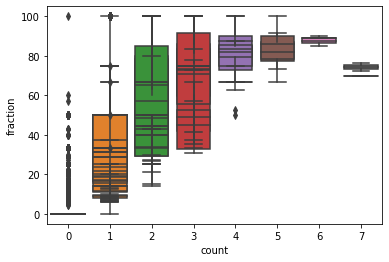

In [27]:
fig, ax = plt.subplots()
cellDict={}
outputDir="./output/merfish/tangram/"
for  c in celltypes:
    cellDict["count"]=typeCountDf[c]
    cellDict["fraction"]=deconvolveDf[c]
    df = pd.DataFrame(cellDict)
    sns.boxplot(x='count',y='fraction',data= df,ax=ax)
    fileName= outputDir  + c+".pdf"
    plt.savefig(fileName)





[0 1 2 3]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.285714285714286, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 40.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.384615384615385, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.333333333333334, 0.0, 0.0, 50.0, 0.0, 0.0, 0.0, 0.0, 11.11111111111111, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.285714285714286, 0.0, 0.0, 0.0, 0.0, 0.0, 12.5, 25.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.666666666666668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

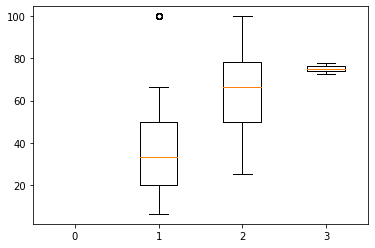

In [37]:
celltypes= ["Astrocyte"]
cellDict={}
for  c in celltypes:
    uniqueCounts= typeCountDf[c].unique()
    print(uniqueCounts)
    for val in uniqueCounts:
        cellDict[val]=[deconvolveDf.iloc[Index][c] for Index  in range(len(deconvolveDf))  if typeCountDf.iloc[Index][c]==val ]
    print(cellDict[0])

    fig, ax = plt.subplots()
    ax.boxplot(cellDict.values())
    ax.set_xticklabels(cellDict.keys())

    typeCountCol=type
    scatterDf=pd.Dataframe(cellDict)    

